# Lattice-Boltzmann analytic check

This is a check that our Lattice-Boltzmann simulation is physically accurate. We do our computation in a domain which is $128$ times $128$. For the our analytic check we do 2D Poiseuille flow and let the channel width we $128-2$ lattice units. The physical requirements is that the physical length is $L=10^-3$ meter and that the mach number stays in the $1>>Ma$. 

First some imports:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from lbm import LBM_solver

Next we set up our domain:

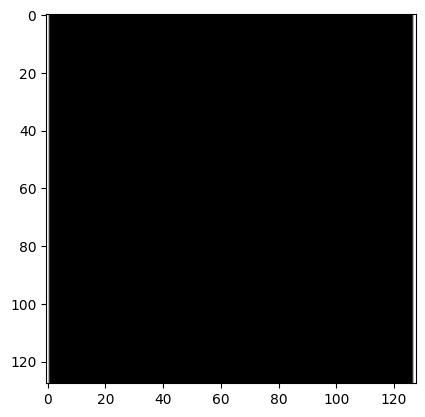

In [13]:
solid = np.zeros((128, 128), dtype=bool)
solid[:,0] = True
solid[:,-1] = True
plt.imshow(solid, cmap='gray')

Then we can perform our simulation:

In [14]:
u, kx, ky, iterations, Ma, Re_latt, dt, tau, Re_lattice = LBM_solver(
        solid=solid,
        max_iterations=50000
    )
print(f"U_physical max: {np.max(u)} m/s")


U_physical max: 1.0704188395732306 m/s


After the simulation is complete we can validate by checking a few things. First we can check that the velocity profile fits the analytic expression of a parabola:

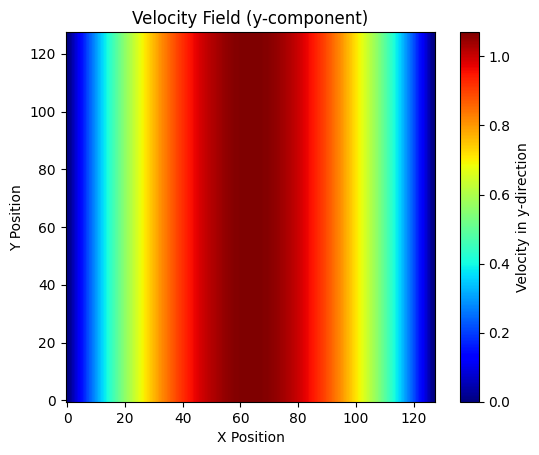

In [15]:
u_y = u[:,:,0]
plt.imshow(u_y, origin='lower', cmap='jet')
plt.colorbar(label='Velocity in y-direction')
plt.title('Velocity Field (y-component)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()

In [16]:
Ny = 128
w = 1e-3          # channel width [m]
nu = 1e-6         # kinematic viscosity [m^2/s]
rho = 1e3         # density [kg/m^3]
g = 10.0          # gravity [m/s^2]
F = rho * g       # body force [N/m^3]

# y coordinates in meters
y = np.linspace(0, w, Ny)
y_center = w / 2

# Analytical velocity profile
u_analytical = (g/ (2 * nu)) * ( (w/2)**2 - (y - y_center)**2 )
print(f"Max analytical velocity: {np.max(u_analytical)} m/s")
print(f"Analytical Reynolds number: {np.max(u_analytical) * w / nu}")

Max analytical velocity: 1.2499224998449996 m/s
Analytical Reynolds number: 1249.9224998449997


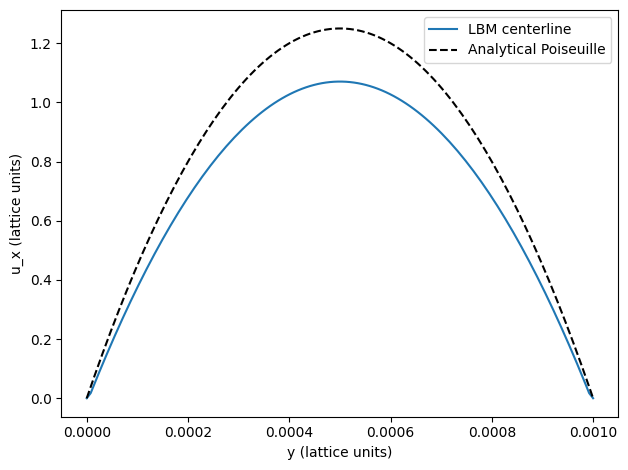

In [17]:
# velocity profile versus theoretical Poiseuille flow

# Profile comparison
plt.plot(y, u[0,:,0], label="LBM centerline")
plt.plot(y, u_analytical, 'k--', label="Analytical Poiseuille")
plt.xlabel("y (lattice units)")
plt.ylabel("u_x (lattice units)")
plt.legend()
# plt.title(f"Profile Comparison\nRelative L2 error = {rel_error:.2e}")

plt.tight_layout()
plt.show()

In [18]:

H_phys = (126/128)*1e-3 

# Theoretical permeability (m^2) for 2D parallel-plate Poiseuille (per unit depth)
k_theory = H_phys**2 / 12.0

# Compare
rel_err_kx = abs(kx - k_theory) / k_theory
rel_err_ky = abs(ky - k_theory) / k_theory

print()
print("Permeability check (theory vs simulation):")
print(f"  H_phys = {H_phys:.6e} m (assumed channel gap)")
print(f"  k_theory = {k_theory:.6e} m^2")
print(f"  kx (sim) = {kx:.6e} m^2   rel error = {rel_err_kx:.3e}")
print(f"  ky (sim) = {ky:.6e} m^2   rel error = {rel_err_ky:.3e}")



Permeability check (theory vs simulation):
  H_phys = 9.843750e-04 m (assumed channel gap)
  k_theory = 8.074951e-08 m^2
  kx (sim) = 8.081334e-08 m^2   rel error = 7.905e-04
  ky (sim) = 4.977463e-24 m^2   rel error = 1.000e+00


In [19]:
Nx = 128
L_physical = 1e-3  # Physical length of the domain in meters
U_physical = g * H_phys**2 / (8 * nu)  # Max velocity in Poiseuille flow
print("U_physical =", U_physical)
U_lattice = 0.1 * (1.0 / np.sqrt(3.0))  # From Ma_target = 0.1
dt = (U_lattice / U_physical) * (L_physical / Nx)
nu_lattice = (nu * dt) / ((L_physical / Nx)**2)
tau = 3.0 * nu_lattice + 0.5
print(tau)

U_physical = 1.2112426757812502
0.5183037229286707


In [20]:
# Inputs (change as needed)
H_phys = 1e-3
nu_phys = 1e-6
Re_phys = 1e2     # or compute from U_phys if you prefer
N = 100
tau = 1.0          # choose 0.6..1.5
cs2 = 1/3

# Derived
H_l = N-1
dx = H_phys / H_l
nu_l = cs2 * (tau - 0.5)

# If you want to match Re:
u_l = Re_phys * nu_l / H_l
Ma = u_l * (3**0.5)
a_l = 8 * u_l * nu_l / (H_l**2)

print("dx", dx, "nu_l", nu_l, "u_l", u_l, "Ma", Ma, "a_l", a_l)


dx 1.0101010101010101e-05 nu_l 0.16666666666666666 u_l 0.16835016835016833 Ma 0.2915910450452655 a_l 2.2902447825074765e-05


/tmp/ipykernel_246257/779457380.py:8: RuntimeWarning: divide by zero encountered in divide
  dt = U_lattice * dx / u


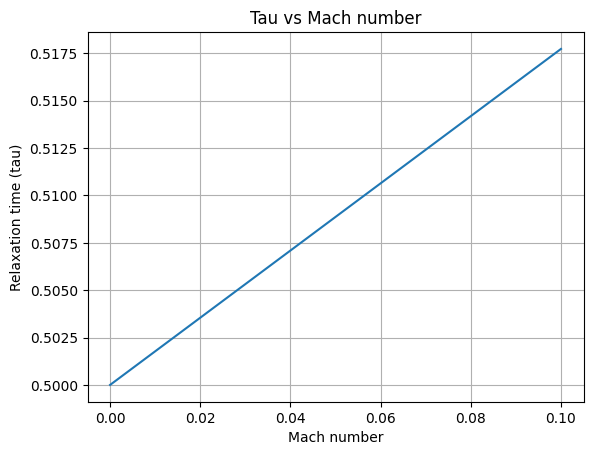

In [23]:
# Tau over Ma number
nu = 1e-6
L = 1e-3
g = 10.0

U_physical = g*(L**2)/(8.0*nu)#Re_target * nu / L_physical
dx = L / 128
dt = U_lattice * dx / u
nu_lattice = nu * dt / (dx * dx)
tau = 3.0 * nu_lattice + 0.5

Ma = np.logspace(-5, -1, 100)
tau_values = []
for Ma_target in Ma:
    U_lattice = Ma_target * (1.0 / np.sqrt(3.0))
    dt = U_lattice * dx / U_physical
    nu_lattice = nu * dt / (dx * dx)
    tau = 3.0 * nu_lattice + 0.5
    tau_values.append(tau)
plt.plot(Ma, tau_values)
plt.xlabel("Mach number")
plt.ylabel("Relaxation time (tau)")
plt.title("Tau vs Mach number")
plt.grid()
plt.show()